In [1]:
import tensorflow as tf
import loadData
import model
import numpy as np
import glob, sys
import matplotlib.pyplot as plt
import tqdm 
%matplotlib inline

sys.path.append("/home/msmith/misc/py/")
sys.path.append("/home/msmith/misc/tfFunctions/")

from dice import dice
from performance import performance
from hStackBatch import hStackBatch

def showBatch(x,y,yPred,unnormalize=1):
    x, y, yPred = [hStackBatch(im) for im in [x,y,yPred]]
    if unnormalize == 1:
        x *= 255
        y *= 255
        yPred *= 255

    x,y,yPred = [im.astype(np.uint8).squeeze()[:,:,::-1] for im in [x,y,yPred]]
    print("*"*100)
    plt.figure(figsize=(15,15))
    plt.subplot(311)
    plt.imshow(x)
    plt.subplot(312)
    plt.imshow(np.vstack((y,yPred)))
    plt.show()

def mse(y,yPred):
	return tf.reduce_mean(tf.square(tf.sub(y,yPred)))

def trainer(loss,learningRate,momentum=0.9):
    return tf.train.AdamOptimizer(learningRate).minimize(loss)



Using TensorFlow backend.


[None, 600, 900, 3]
[None, 300, 450, 32]
[None, 150, 225, 64]
[None, 75, 113, 96]
[None, 38, 57, 128]
[None, 38, 57, 3]
[None, 38, 57, 3]
50 iterations.
****************************************************************************************************


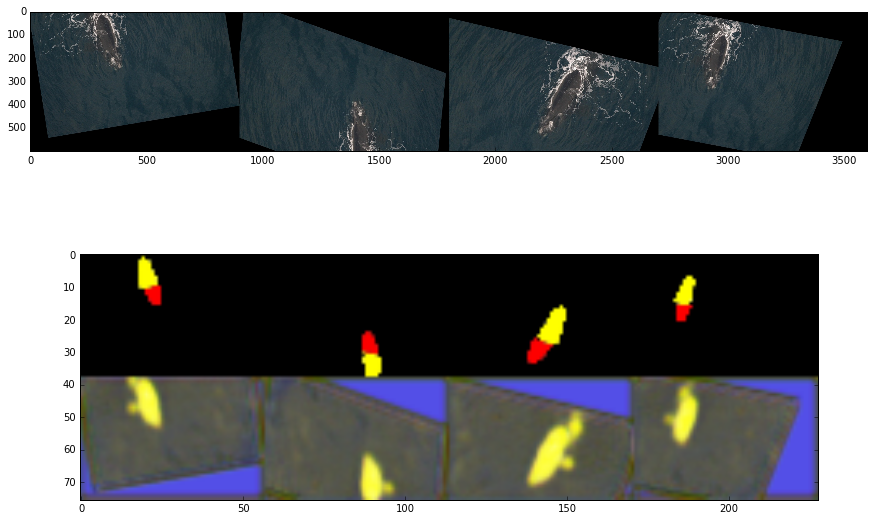

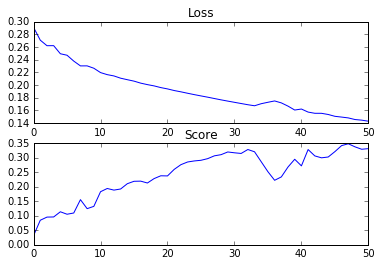

100 iterations.
****************************************************************************************************


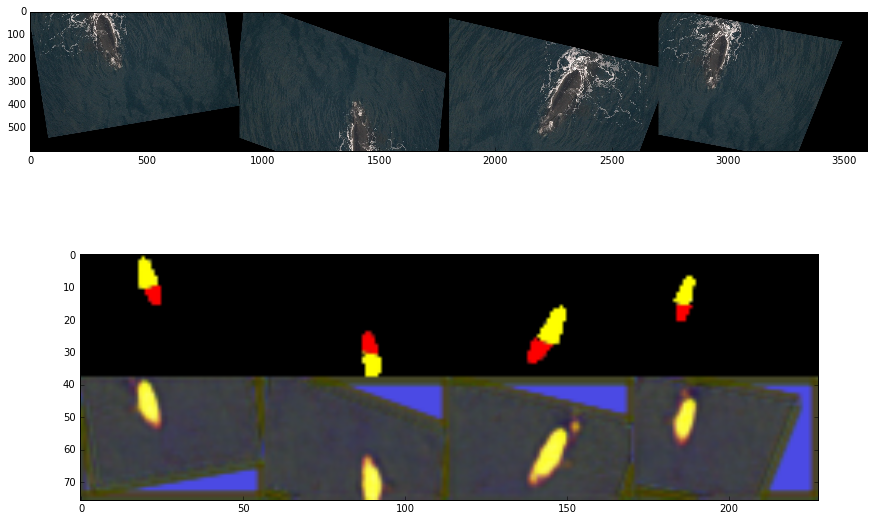

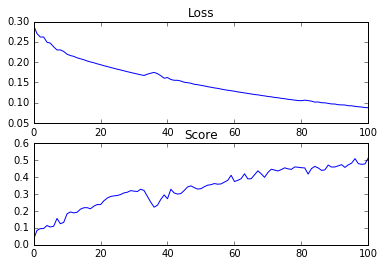

150 iterations.
****************************************************************************************************


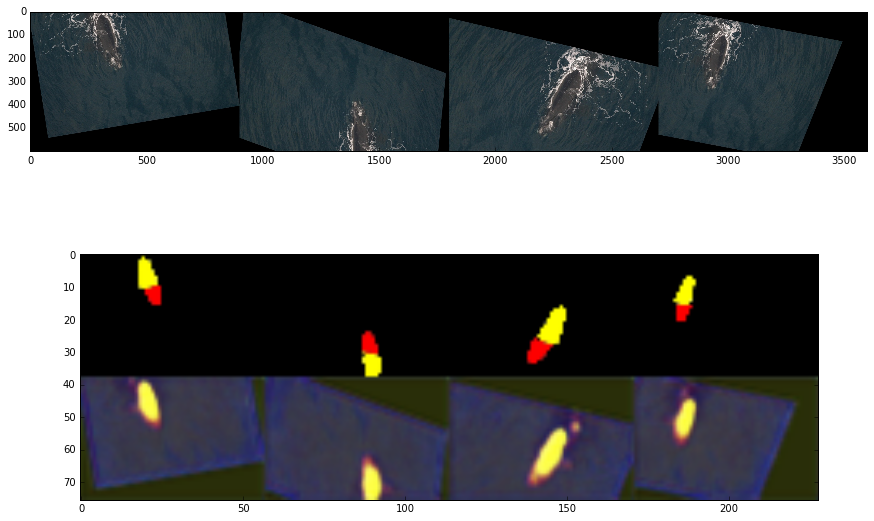

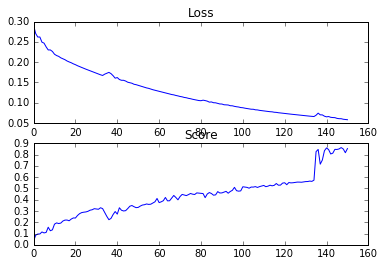

In [ ]:
if __name__ == "__main__":

        import matplotlib.pyplot as plt

        learningRate = 0.01
        load = 0
        diceThreshold = 0.5
        paths = glob.glob("../augmented/x_*")
        feeder = loadData.feed(inDims = [4,600,900,3], outDims = [4,38,57,3], paths = paths)

        x, y, yPred = model.main()

        loss = mse(yPred,y)
        diceScore, _ = dice(yPred,y,diceThreshold)
        lr = tf.placeholder(tf.float32)
        train = trainer(loss,lr)

        saver = tf.train.Saver()
        
        trPerformance = performance()
        tePerformance = performance()
        
        init = tf.initialize_all_variables()
        X,Y = feeder.next()
        with tf.Session() as sess:
            sess.run(init)

            if load == 1: 
                saver.restore(sess,"model.ckpt")

            for i in xrange(500):
                
                _, loss_, diceScore_, yPred_ = sess.run([train,loss,diceScore,yPred], feed_dict = {x:X,y:Y,lr:learningRate})
                trPerformance.add(loss_,diceScore_)
                if i % 200 == 0 and i > 0 and i < 1000:
                    learningRate/= 1.5
                    print("Dropped learning rate to {0:.6f}".format(learningRate))

                if i % 50  == 0 and i > 0 :
                    print("{0} iterations.".format(i))
                    showBatch(X,Y,yPred_)
                    trPerformance.displayPerformance()

        